<a href="https://colab.research.google.com/github/Chevron9/iannwtf/blob/master/Exercise4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [9]:
train_dataset = tfds.load('Malaria', split="train[:80%]", as_supervised=True)
test_dataset = tfds.load('Malaria', split="train[80%:]", as_supervised=True)


#resize the images and make the labels a one hot vector
train_dataset = train_dataset.map(lambda x,y: (tf.image.resize(x, [125,125]), (tf.reshape(tf.one_hot(y, 2), (-1,)))))
test_dataset = test_dataset.map(lambda x,y: (tf.image.resize(x, [125,125]), (tf.reshape(tf.one_hot(y, 2), (-1,)))))
#normalize the data
train_dataset = train_dataset.map(lambda x,y: (tf.image.per_image_standardization(
    x), y))
test_dataset = train_dataset.map(lambda x,y: (tf.image.per_image_standardization(
    x), y))
train_numpy= tfds.as_numpy(train_dataset)


for i in train_numpy:
  print((i[0])[3][50])
  break


[1.1266909  0.13065453 0.31333902]


In [10]:
#shuffel, prefetch and batch the datasets
train_dataset = train_dataset.batch(64).shuffle(buffer_size=64).prefetch(128)
test_dataset = test_dataset.batch(64).shuffle(buffer_size=64).prefetch(128)

In [19]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the five layers.
        self.conv_layer_1= tf.keras.layers.Conv2D(filters= 32, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.sigmoid, input_shape = (64,125,125,3))

        self.pool_layer_2= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)

        self.conv_layer_3= tf.keras.layers.Conv2D(filters= 32, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.sigmoid, input_shape = (64,125,125,3))

        self.pool_layer_4= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)

        self.conv_layer_5= tf.keras.layers.Conv2D(filters= 32, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.sigmoid, input_shape = (64,125,125,3))

        self.pool_layer_6= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)

        self.conv_layer_7= tf.keras.layers.Conv2D(filters= 32, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.sigmoid, input_shape = (64,125,125,3))

        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.hidden_layer_9 = tf.keras.layers.Dense(units=256,activation=tf.keras.activations.sigmoid)

        self.output_layer_10 = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)
    @tf.function 
    def call(self, x):
        # Define the forward step.
        x = self.conv_layer_1(x)
        x = self.pool_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.pool_layer_4(x)
        x = self.conv_layer_5(x)
        x = self.pool_layer_6(x)
        x = self.conv_layer_7(x)
        x = self.global_pooling_layer_8(x)
        #x = self.hidden_layer_9(x)
        x = self.output_layer_10(x)
        return x

In [20]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  

In [21]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 15
learning_rate = 0.00005
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14


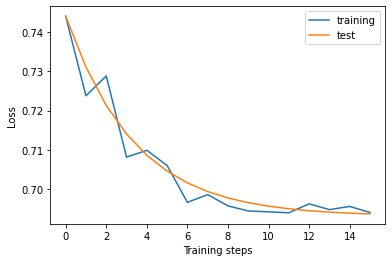

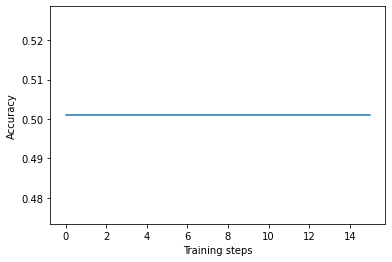

In [22]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()